# IceCube - Neutrinos in Deep Ice
## Overview
**Goal of the Competition**

The goal of this competition is to predict a neutrino particle’s direction. You will develop a model based on data from the "IceCube" detector, which observes the cosmos from deep within the South Pole ice.

**Context**

One of the most abundant particles in the universe is the neutrino. While similar to an electron, the nearly massless and electrically neutral neutrinos have fundamental properties that make them difficult to detect. Yet, to gather enough information to probe the most violent astrophysical sources, scientists must estimate the direction of neutrino events. If algorithms could be made considerably faster and more accurate, it would allow for more neutrino events to be analyzed, possibly even in real-time and dramatically increase the chance to identify cosmic neutrino sources. Rapid detection could enable networks of telescopes worldwide to search for more transient phenomena.

Researchers have developed multiple approaches over the past ten years to reconstruct neutrino events. However, problems arise as existing solutions are far from perfect. They're either fast but inaccurate or more accurate at the price of huge computational costs.

The IceCube Neutrino Observatory is the first detector of its kind, encompassing a cubic kilometer of ice and designed to search for the nearly massless neutrinos. An international group of scientists is responsible for the scientific research that makes up the IceCube Collaboration.

By making the process faster and more precise, you'll help improve the reconstruction of neutrinos. As a result, we could gain a clearer image of our universe.

In [2]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression

PATH_DATASET = "/kaggle/input/icecube-neutrinos-in-deep-ice"

# Dataset import and description

**sensor_geometry.csv** The **x**, **y**, and **z** positions for each of the 5160 IceCube sensors. The row index corresponds to the sensor_idx feature of pulses. The x, y, and z coordinates are in units of meters, with the origin at the center of the IceCube detector. The coordinate system is right-handed, and the z-axis points upwards when standing at the South Pole. You can convert from these coordinates to azimuth and zenith with the following formulas (here the vector (x,y,z) is normalized):

# Detector break down by groups

All sensors can be broken down into several groups by their relative performance.

In [3]:
sensor_geometry = pd.read_csv(os.path.join(PATH_DATASET, 'sensor_geometry.csv'))
print(f"length: {len(sensor_geometry)}")
print(f"events: {len(sensor_geometry.index.unique())}")
sensor_geometry.head()

length: 5160
events: 5160


,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95


In [4]:
sensor_geometry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sensor_id  5160 non-null   int64  
 1   x          5160 non-null   float64
 2   y          5160 non-null   float64
 3   z          5160 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 161.4 KB


Based on the information available, we can divide all sensors into following groups:

- DeepCore sensors - the best quantum efficiency.
- Detectors under the dust layer - second best QE
- Detectors above the dust layer - third best QE
- Detectors inside the dust layer - worst QE
Now it's time to create new feature, for now categorical.

In [5]:
def detector_group(x, z):
    """
    Assigns values - deepcore, dustlayer, abovedust, underdust -
    depending on sensor coordinates x and z
    """
    
    # Define functions for each sensor category
    def is_deepcore(x, z):
        return x in {57.2, -9.68, 31.25, 72.37, 113.19, 106.94, 41.6, -10.97} or \
               (x in {46.29, 194.34, 90.49, -32.96, -77.8, 1.71, 124.97} and 
                ((z <= 186.02 and z >= 95.91) or 
                 (z <= -157 and z >= -511)))
    
    def is_dustlayer(z):
        return z <= 0 and z >= -155
    
    def is_abovedust(x, z):
        return z > 0 and not is_deepcore(x, z) and not is_dustlayer(z)
    
    def is_underdust(x, z):
        return not is_deepcore(x, z) and not is_dustlayer(z) and not is_abovedust(x, z)
    
    # Check which sensor category the coordinates belong to
    if is_deepcore(x, z):
        return "deepcore"
    
    if is_dustlayer(z):
        return "dustlayer"
    
    if is_abovedust(x, z):
        return "abovedust"
    
    return "underdust"

In [6]:
sensor_geometry['sensor_group'] = sensor_geometry.apply(lambda row: detector_group(row['x'], row['z']), axis=1)
sensor_geometry.head()

,sensor_id,x,y,z,sensor_group
0,0,-256.14,-521.08,496.03,abovedust
1,1,-256.14,-521.08,479.01,abovedust
2,2,-256.14,-521.08,461.99,abovedust
3,3,-256.14,-521.08,444.97,abovedust
4,4,-256.14,-521.08,427.95,abovedust


In [7]:
scatter3d = px.scatter_3d(sensor_geometry, x='x', y='y', z='z',color='sensor_group', opacity=0.7)
scatter3d.update_traces(marker = dict(size = 2, symbol = "diamond-open"))
scatter3d.update_coloraxes(showscale = False)
scatter3d.update_layout(template = "plotly", font = dict(family = "Arial", size = 12, color = "#9e97ff"))
scatter3d.show()

We've broken down all sensors into groups, depending on their quantum efficiency. Though, there is more to sensor QE, than just it's location within designated groups, even this rough division can give us additional information that can, probably, increase the score in the competition.

# Detectors relative performance
Each detector is unique and has slightly different performance comparing to others. Unfortunately there is little available information to assaign a certain value to every detector. However, albeit roughly, we still can give an estimate of relative performance of groups of sensors we created.

According to R. Abbasi et al, DeepCore sensors are roughly 1.35 times more sensitive than "normal" detectors. We also know that dust layer detectors are roughly 0.5 - 0.6 time less sensitive. Based on this information we can engineer an additional feature - DOM's relative quantum efficiency.


In [8]:
def relative_qe(group):
    """
    Returns a relative quantum efficiency of a sensor group according to the following rules:
    - 1.35, if sensor is deepcore;
    - 0.95, if sensor is abovedust;
    - 1.05 if sensor is underdust;
    - 0.6 if sensor is dustlayer
    """
    if group == 'deepcore':
        return 1.35
    if group == 'abovedust':
        return 0.95
    if group == 'underdust':
        return 1.05
    else:
        return 0.6

In [9]:
sensor_geometry['relative_qe'] = sensor_geometry['sensor_group'].apply(relative_qe)
sensor_geometry.head()

,sensor_id,x,y,z,sensor_group,relative_qe
0,0,-256.14,-521.08,496.03,abovedust,0.95
1,1,-256.14,-521.08,479.01,abovedust,0.95
2,2,-256.14,-521.08,461.99,abovedust,0.95
3,3,-256.14,-521.08,444.97,abovedust,0.95
4,4,-256.14,-521.08,427.95,abovedust,0.95


We can use one hot encoding to break down the categorical variable, if we want to, or just go with the numerical variable.

# Browse meta data¶

- **batch_id** (int): the ID of the batch the event was placed into.
- **event_id** (int): the event ID.
- **[first/last]_pulse_index** (int): index of the first/last row in the features dataframe belonging to this event.
- **[azimuth/zenith]** (float32): the [azimuth/zenith] angle in radians of the neutrino. A value between 0 and 2*pi for the azimuth and 0 and pi for zenith. The target columns. Not provided for the test set. The direction vector represented by zenith and azimuth points to where the neutrino came from.
- **NB**: Other quantities regarding the event, such as the interaction point in x, y, z (vertex position), the neutrino energy, or the interaction type and kinematics are not included in the dataset.

In [10]:
train_meta = pd.read_parquet(os.path.join(PATH_DATASET, 'train_meta.parquet'))
print(f"length: {len(train_meta)}")
print(f"events: {len(train_meta.index.unique())}")
train_meta.head()

length: 131953924
events: 131953924


,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117


In [11]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131953924 entries, 0 to 131953923
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   batch_id           int64  
 1   event_id           Int64  
 2   first_pulse_index  int64  
 3   last_pulse_index   int64  
 4   azimuth            float64
 5   zenith             float64
dtypes: Int64(1), float64(2), int64(3)
memory usage: 6.0 GB


In [12]:
train_meta.isnull().sum()

batch_id             0
event_id             0
first_pulse_index    0
last_pulse_index     0
azimuth              0
zenith               0
dtype: int64

In [13]:
test_meta = pd.read_parquet(os.path.join(PATH_DATASET, 'test_meta.parquet'))
print(f"length: {len(test_meta)}")
print(f"events: {len(test_meta.index.unique())}")
test_meta

length: 3
events: 3


,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


Before doing a prediction let's explore the data a bit more. But before let's make sure what azimuth and zenith represent. The following image does a good job explaining both of them:

<div style="width:100%;text-align: center;"> <img align=middle src="https://c.tadst.com/gfx/1200x675/horizontal-coordinate-system.png?1" width="600" height="600" class ="center"/></div>

From the meta data file let's see the target azimuth and zenith distribution. We want to know what’s the most prominent direction of the neutrino in the dataset.



<AxesSubplot:xlabel='zenith'>

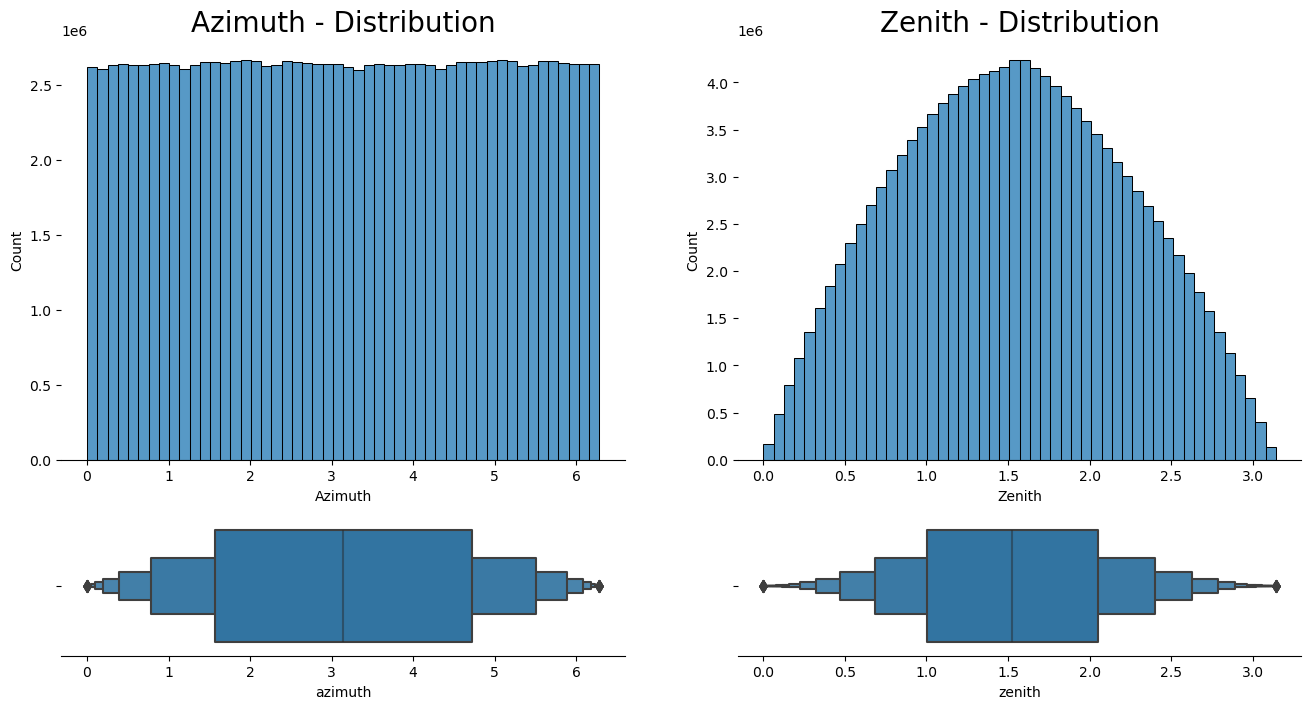

In [14]:
# Plot Azimuth and Zenith 

fig, ax =plt.subplots(2,2,gridspec_kw={'height_ratios': [3, 1]},figsize=(16,8))

sns.despine(right=True, top=True, left=True)

ax[0,0].tick_params(axis='x', labelrotation=0)
ax[0,0].tick_params(axis='y', labelrotation=0)
ax[0,0].set_title('Azimuth - Distribution', size=20)
ax[0,0].set(xlabel='Azimuth', ylabel='Count')

ax[0,1].tick_params(axis='x', labelrotation=0)
ax[0,1].tick_params(axis='y', labelrotation=0)
ax[0,1].set_title('Zenith - Distribution', size=20)
ax[0,1].set(xlabel='Zenith', ylabel='Count')

sns.histplot(data=train_meta, x='azimuth',y=None,bins=50,ax=ax[0,0])
sns.histplot(data=train_meta, x='zenith',y=None,bins=50,ax=ax[0,1])

sns.boxenplot(data=train_meta, x='azimuth',y=None,ax=ax[1,0])
sns.boxenplot(data=train_meta, x='zenith',y=None,ax=ax[1,1])

The azimuth ranges from 0° to 360° and it seems consistent throughout the whole meta data. This is normally what we expected.

Now the Zenith which ranges from 0° to 180° tells us that we are most likely to find a neutrino coming at an angle between 60° and 120° (90° being the most common). It appears that horizontal(trajectories with zenith around 0 or 3 radians) are quite rare.

Lastly for a better visualization let's compare both targets.

<AxesSubplot:title={'center':'Azimuth vs Zenith'}, xlabel='Azimuth / Zenith', ylabel='Count'>

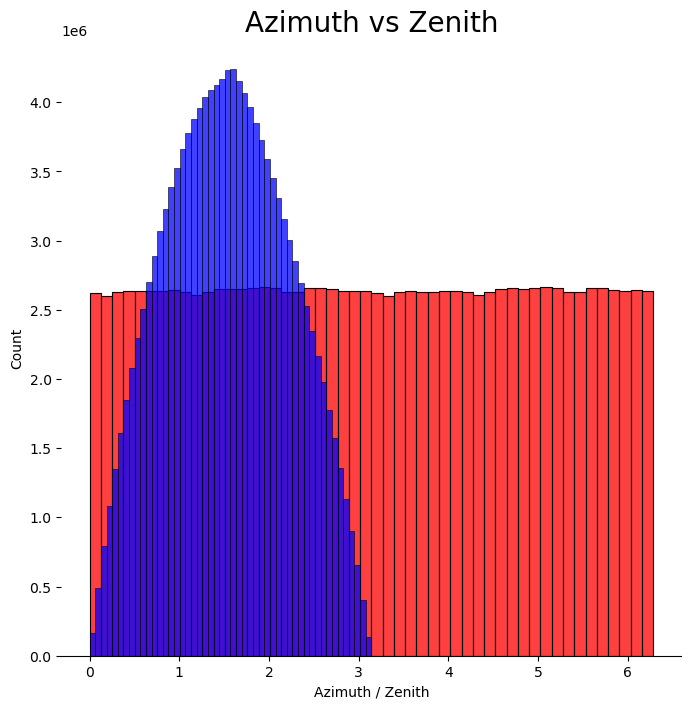

In [15]:
# Overlaping the two graphs Blue is Azimuth Red is Zenith

fig, ax =plt.subplots(figsize=(8,8))

sns.despine(right=True, top=True, left=True)

ax.set_title('Azimuth vs Zenith', size=20)
ax.set(xlabel='Azimuth / Zenith', ylabel='Count')

sns.histplot(data=train_meta,x='azimuth',color='r',bins=50,ax=ax)
sns.histplot(data=train_meta,x='zenith',color='b',bins=50,ax=ax)

In [16]:
train_batch_477 = pd.read_parquet(os.path.join(PATH_DATASET, 'train/batch_477.parquet')).reset_index()
print(f"length: {len(train_batch_477)}")
print(f"events: {len(train_batch_477['event_id'].unique())}")
train_batch_477.head()

length: 33250753
events: 200000


,event_id,sensor_id,time,charge,auxiliary
0,1549463681,1479,7390,0.625,True
1,1549463681,1479,7403,0.625,True
2,1549463681,3223,7643,0.725,True
3,1549463681,2279,8150,0.475,True
4,1549463681,3386,8658,1.025,True


In [17]:
train_batch_477[train_batch_477['event_id'] == 1549463681]

,event_id,sensor_id,time,charge,auxiliary
0,1549463681,1479,7390,0.625,True
1,1549463681,1479,7403,0.625,True
2,1549463681,3223,7643,0.725,True
3,1549463681,2279,8150,0.475,True
4,1549463681,3386,8658,1.025,True
...,...,...,...,...,...
77,1549463681,4772,22059,0.975,True
78,1549463681,3831,22923,1.275,True
79,1549463681,2906,23088,0.275,True
80,1549463681,3232,23158,0.725,True


In [18]:
test_batch_661 = pd.read_parquet(os.path.join(PATH_DATASET, 'test/batch_661.parquet')).reset_index()
print(f"length: {len(test_batch_661)}")
print(f"events: {len(test_batch_661['event_id'].unique())}")
test_batch_661.head()

length: 378
events: 3


,event_id,sensor_id,time,charge,auxiliary
0,2092,4066,6170,1.275,True
1,2092,3512,6374,0.975,True
2,2092,897,6378,1.475,True
3,2092,2060,6590,0.925,True
4,2092,3072,6625,1.075,True


Great, so what information does this event tell us?

- `sensor_id`: tells us which of the 5160 IceCube sensors was triggered by this event. We'll explore this in more depth
- `time`: this tells the "time of the pulse in nanoseconds in the current event time window". I will assume that this depends on the velocity of the neutrino
- `charge`: an estimate of the charge. This is a float number
- `auxiliary`: This means that this event might actually occur from the noise

In [19]:
data_ex = pd.merge(train_batch_477, sensor_geometry, on='sensor_id')
data_total_events = pd.merge(data_ex, train_meta[train_meta["batch_id"] == 477].reset_index()
                             [["event_id", "azimuth", "zenith",]], on="event_id")
data_total_events["event_id"].unique()

array([1549463681, 1549463714, 1549465043, ..., 1551074551, 1550573778,
       1550179511])

In [20]:
tmp = data_total_events[data_total_events["event_id"] == 1549465043].reset_index()
tmp

,index,event_id,sensor_id,time,charge,auxiliary,x,y,z,sensor_group,relative_qe,azimuth,zenith
0,190,1549465043,1479,10207,1.375,False,-121.77,-171.03,-161.54,underdust,1.05,4.912762,1.513516
1,191,1549465043,1479,10227,1.075,False,-121.77,-171.03,-161.54,underdust,1.05,4.912762,1.513516
2,192,1549465043,1479,10799,7.325,False,-121.77,-171.03,-161.54,underdust,1.05,4.912762,1.513516
3,193,1549465043,3699,11714,1.525,False,-189.98,257.42,-162.20,underdust,1.05,4.912762,1.513516
4,194,1549465043,3699,11893,1.375,False,-189.98,257.42,-162.20,underdust,1.05,4.912762,1.513516
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,251,1549465043,1480,10470,0.575,False,-121.77,-171.03,-178.56,underdust,1.05,4.912762,1.513516
62,252,1549465043,1481,10845,1.175,False,-121.77,-171.03,-195.58,underdust,1.05,4.912762,1.513516
63,253,1549465043,582,10874,0.475,True,35.54,-364.83,-217.16,underdust,1.05,4.912762,1.513516
64,254,1549465043,761,13123,0.725,True,405.83,-306.38,-202.72,underdust,1.05,4.912762,1.513516


In [21]:
def plot(df_event):
    
    x = np.array(df_event["x"] - np.average(df_event["x"]))
    y = np.array(df_event["y"] - np.average(df_event["y"]))
    z = np.array(df_event["z"] - np.average(df_event["z"]))
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    charge = df_event["charge"].values
    
    # Create a linear regression object and fit the data
    reg = LinearRegression().fit(np.column_stack((x, y)), z, sample_weight=1/r)
    # Extract the coefficients of the plane
    m_x, m_y = reg.coef_  # slopes
    b = reg.intercept_  # y-intercept
    # Create a scatter3d trace with x, y, and z positions from the df_event DataFrame
    trace_points = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            # size=2,
            size=3,# np.clip(df_event['charge'], 0, 5),
            # width=df_event['charge'],
            color='blue',
            colorscale='Viridis',
            opacity=0.8
        ),
        name='Points'
    )
    
    # Convert the azimuth and zenith angles to radians
    phi = df_event['azimuth']
    theta =   df_event['zenith']

    # Calculate the line endpoints in x, y, and z coordinates
    x2 = np.linspace(-800, 800, len(df_event)) * (np.cos(phi) * np.sin(theta))
    y2 = np.linspace(-800, 800, len(df_event)) * (np.sin(theta) * np.sin(phi))
    z2 = np.linspace(-800, 800, len(df_event)) * np.cos(theta)
    
    trace_fitten_points = go.Scatter3d(
        x=x2,
        y=y2,
        z=m_x * x2 + m_y * y2 + b,
        mode='lines',
        line=dict(
            color='purple',
            width=10
        ),
        name='Fitted regression line'
    )
    
    # Create a line trace with the calculated endpoints
    trace_line = go.Scatter3d(
        x=x2,
        y=y2,
        z=z2,
        mode='lines',
        line=dict(
            color='red',
            width=10
        ),
        name='Target Line'
    )
    
    # Combine the scatter and line traces into a np.single plot
    fig = go.Figure(data=[trace_points, trace_line, trace_fitten_points])

    # Add axis labels and a title
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='Interactive 3D plot'
    )

    # Display the plot in Jupyter Notebook or in a web browser
    fig.show()

In [22]:
df_event = data_total_events[data_total_events["event_id"] == data_total_events["event_id"].unique()[0]].reset_index(drop=True)
plot(df_event)

In [23]:
df_event = data_total_events[data_total_events["event_id"] == data_total_events["event_id"].unique()[1]].reset_index(drop=True)
plot(df_event)

# Explore the time

Let's explore the `time` variable in the example event.

Here is the result of a `.describe()` and histogram.

In [24]:
train_batch_477['time'].describe()

count    3.325075e+07
mean     1.313736e+04
std      4.713829e+03
min      5.713000e+03
25%      1.057200e+04
50%      1.184400e+04
75%      1.393800e+04
max      9.739200e+04
Name: time, dtype: float64

Text(0.5, 0, 'time')

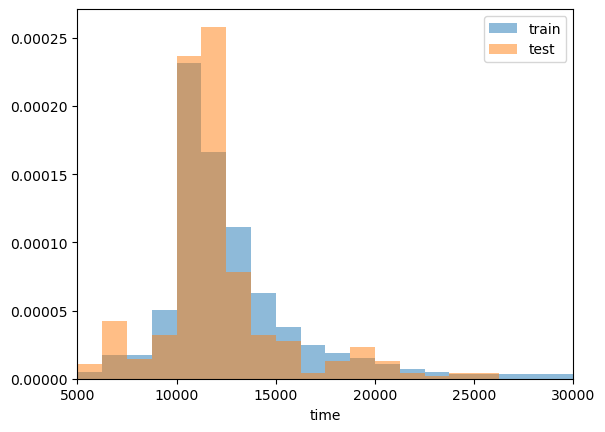

In [25]:
plt.hist(train_batch_477["time"], bins=20, alpha=0.5, range=(5000, 30000), density=True, label='train')
plt.hist(test_batch_661["time"], bins=20, alpha=0.5, range=(5000, 30000), density=True, label='test');
plt.xlim(5000, 30000)
plt.legend(loc="best")
plt.xlabel("time")

97392


Text(0.5, 0, 'time')

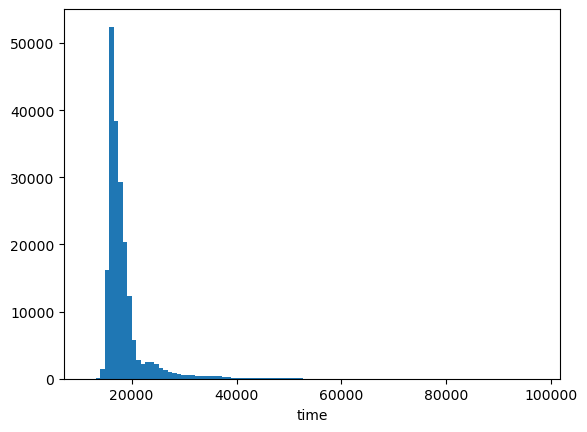

In [26]:
max_times = train_batch_477.groupby("event_id").max("time")["time"]
plt.hist(max_times.values, bins=100);
print(np.max(max_times))
plt.xlabel("time")

# Explore the charge

Let's explore the `charge` variable in the example event.

Here is the result of a `.describe()` and histogram.

In [27]:
train_batch_477['charge'].describe()

count    3.325075e+07
mean     4.222130e+00
std      1.748274e+01
min      2.500000e-02
25%      7.750000e-01
50%      1.075000e+00
75%      1.825000e+00
max      3.131375e+03
Name: charge, dtype: float64

There seem to be some outliers in the charge 

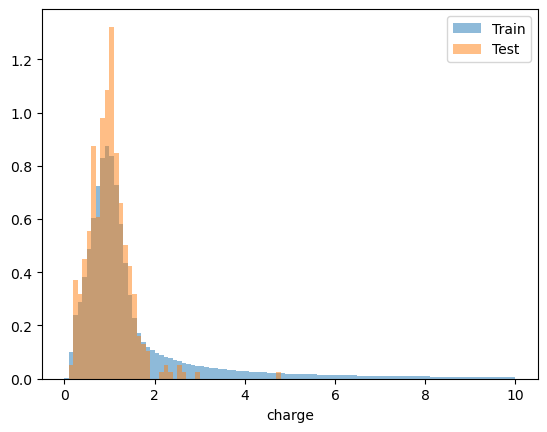

In [28]:
plt.hist(train_batch_477["charge"], alpha=0.5, bins=100, density=True, range=(0, 10), label="Train");
plt.hist(test_batch_661["charge"],alpha=0.5,  bins=100,density=True, range=(0, 10), label="Test");


plt.xlabel("charge")
plt.legend(loc="best")

In [29]:
percentage_gt_2_train = np.sum(train_batch_477["charge"] > 2) / len(train_batch_477["charge"])
percentage_gt_2_test = np.sum(test_batch_661["charge"] > 2) / len(test_batch_661["charge"])
percentage_gt_2_train, percentage_gt_2_test

(0.23452783159527243, 0.023809523809523808)

In [30]:
np.max(test_batch_661["charge"])

4.775000095367432

In [31]:
np.sum(train_batch_477["charge"] > 4.78) / len(train_batch_477["charge"])

0.11672225889140014

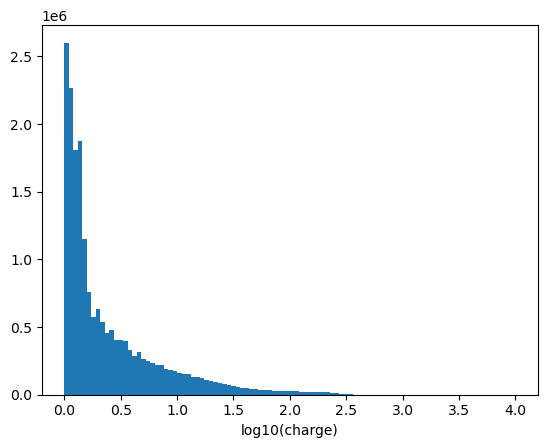

In [32]:
plt.hist(np.log10(train_batch_477["charge"]), bins=100, range=(0, 4));
plt.xlabel("log10(charge)");

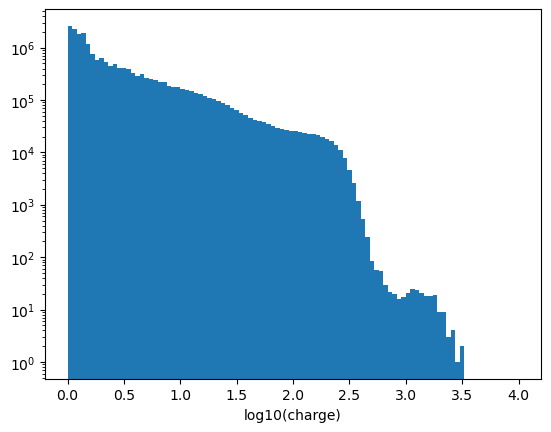

In [33]:
plt.hist(np.log10(train_batch_477["charge"]), bins=100, range=(0, 4));
plt.yscale('log')
plt.xlabel("log10(charge)");

## Understanding the targets

A line in 3D space in this competition is represented as an intersection of `azimuth` and `zenith`. In maths, these are the angles $\varphi$ and $\theta$ of the spherical system:
​
​
​
 ![https://mathworld.wolfram.com/images/eps-svg/SphericalCoordinates_1201.svg](https://mathworld.wolfram.com/images/eps-svg/SphericalCoordinates_1201.svg) .
 
 
 So, a fixed `azimuth` is a cone, and a fixed `zenith` angle is a half-plane. If you intersect the two, you get a line. You can check the middle and right plots below, which are defined as constant zenith and constant azimuth respectively: 
 
 
 ![https://math.libretexts.org/@api/deki/files/3550/CNX_Calc_Figure_12_07_019.jpg?revision=1&size=bestfit&width=623&height=262](https://math.libretexts.org/@api/deki/files/3550/CNX_Calc_Figure_12_07_019.jpg?revision=1&size=bestfit&width=623&height=262)
 


In [34]:
# convert to x, y, z coordinate
train_meta["x"] = np.cos(train_meta["azimuth"]) * np.sin(train_meta["zenith"])
train_meta["y"] = np.sin(train_meta["azimuth"]) * np.sin(train_meta["zenith"])
train_meta["z"] = np.cos(train_meta["zenith"])

# sampling 10000
df_train_sample = train_meta.sample(10000)

# 3d plot
fig = px.scatter_3d(df_train_sample, x='x', y='y', z='z', color='z', opacity=1)
fig.update_traces(marker_size=1)
fig.show()

The target variable is uniformly distributed over the sphere.

## Meta-feature exploration
Let's explore how large is the "context" of a given target signal.

In [35]:
contextual_lengths = train_meta["last_pulse_index"] - train_meta["first_pulse_index"]
print("min/max contextual length:", np.min(contextual_lengths), np.max(contextual_lengths))

min/max contextual length: 4 178249


Text(0.5, 0, 'contextual length')

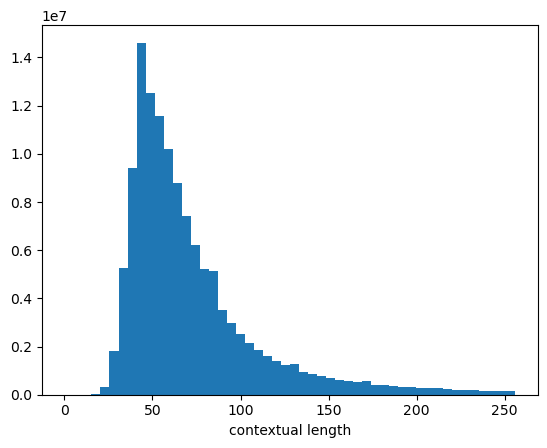

In [36]:
plt.hist(contextual_lengths, bins=50, range=(0, 256));
plt.xlabel("contextual length")

In [37]:
print(f"number of elements greater than 256 context size: {np.sum(contextual_lengths > 256) / len(contextual_lengths):.3f}")

number of elements greater than 256 context size: 0.041


min/max contextual length: 1 110275
number of elements greater than 128 context size: 0.059


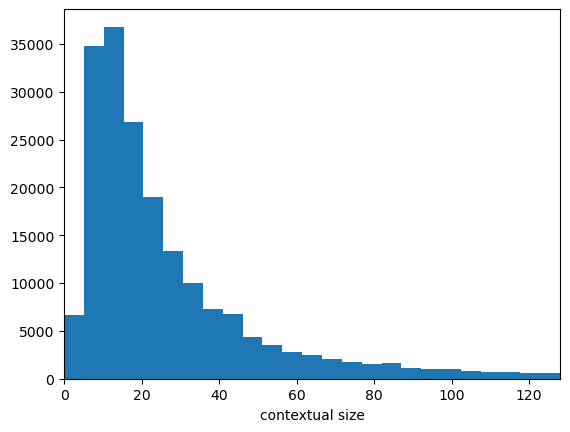

In [38]:
# Make the same exploration, but taking only `auxiliary`=False
df_batch = pd.read_parquet("/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet").reset_index()
df_batch = df_batch[df_batch["auxiliary"]==False].reset_index()
contextual_lengths = df_batch.groupby('event_id').size().values
print("min/max contextual length:", np.min(contextual_lengths), np.max(contextual_lengths))

plt.hist(contextual_lengths, bins=50, range=(0, 256));
plt.xlabel("contextual size")
plt.xlim(0, 128)

print(f"number of elements greater than 128 context size: {np.sum(contextual_lengths > 128) / len(contextual_lengths):.3f}")